In [1]:
import os
import sys

cwd = os.getcwd()
sys.path.append(os.path.join(cwd, '..'))

from sklearn.externals import joblib
from aye import *
from aye.preprocessing import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Reader
reader = DataReader(rel_dir='images', ext='jpg')

# Detector
clf = joblib.load('../model/svc.pkl')
scaler = joblib.load('../model/scaler.pkl')
detector = FruitDetector(clf, scaler)

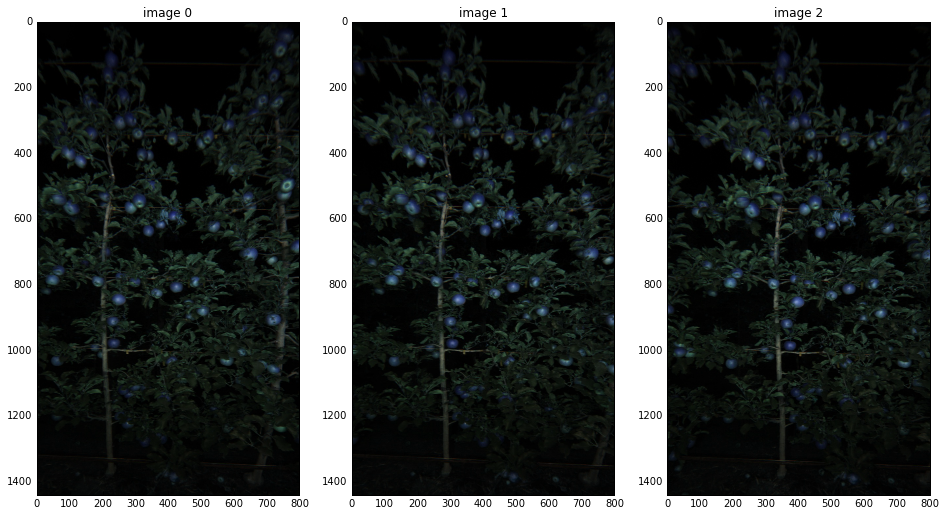

In [3]:
# Load n images
n = 3
images = []
for i in range(n):
    im = reader.read_image(i)
    im = rotate_image(im)
    im = im[:1440, 200:1000, :]
    images.append(im)

def plot_images(images):
    fig = plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        ax = fig.add_subplot(1, n, i + 1)
        ax.imshow(image)
        ax.set_title('image {0}'.format(i))

plot_images(images)

number of blobs in image0: 61


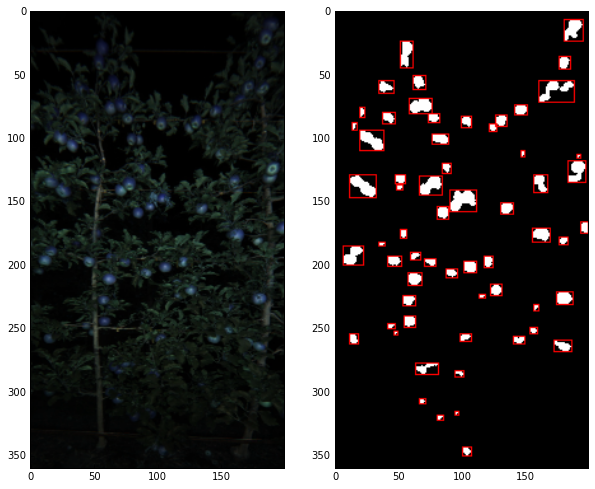

In [4]:
# Detect in image0
s0, bw0 = detector.detect(images[0])
blobs0, bw0 = region_props(bw0)

disp_bgr = np.array(s0.im_raw, copy=True)
disp_bw = cv2.cvtColor(bw0, cv2.COLOR_GRAY2RGB)

# Draw all detections
draw_bboxes(disp_bw, blobs0['bbox'], color=(255, 0, 0))
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(121)
plt.imshow(disp_bgr)
ax = fig.add_subplot(122)
plt.imshow(disp_bw, cmap=plt.cm.gray)
print('number of blobs in image0: {0}'.format(len(blobs0)))

In [9]:
# Make a FruitTrack out of each detection
class FruitTrack(object):
    def __init__(self, blob):
        self.blob = blob
        self.kf = KalmanFilter(blob['bbox_center'])
    
    def predict(self, flow):
        pass
    
    def correct(self, blob):
        pass